# Laboratorio 07: Redes Neuronales Artificiales (I)

Diseñar e implementar una rede neuronal artificial para reconocer piel humana en imágenes fotográficas (segmentación). Para el laboratorio cuenta con una base de datos que contiene un listado de colores RGB donde se indica si ese color es piel o no. Se debe implementar un clasificador utilizando una red neuronal poco profunda y luego aplicarlo a una imagen para poder analizar los resultados obtenidos.

**Objetivos:**
*   Leer un archivo en texto plano y convertirlo a un formato manejable (DataFrame).
*   Analizar la distribución de datos de cada uno de los atributos por medio de gráficos.
*   Analizar la relación entre los atributos de la base de datos y su variable clase.
*   Implementar una red neural.


# Laboratorio 07: Redes Neuronales Artificiales (II)

**Materiales:**

*   Listado de base de datos de prueba: https://archive.ics.uci.edu/ml/datasets.php (UCI - Machine Learning Repository)
   * Skin Segmentation Data Set: https://archive.ics.uci.edu/ml/datasets/Skin+Segmentation


**Se Pide:**

1. Analizar los datos de SKin Segmentación Data Set utilizando el material visto en clases. Como resultados se espera un análisis de datos de acuerdo a los objetivos propuestos.
2. Separar el conjunto de entrenamiento y pruebas.
3. Implementar la red neuronal artificial.
4. Segmentar una imagen destacando en blanco los pixeles que son de piel y en negro los de no piel.

## Skin Segmentation Data Set

### Leer los datos

In [ ]:
import pandas as pd

# Leer los datos
df = pd.read_csv('Skin_NonSkin.txt', sep='\t', header=None, names=['R', 'G', 'B', 'Class'])

df.head()

### Distribución de los datos

In [ ]:
# Graficar variables
import matplotlib.patches as mpatches

import collections
import matplotlib.pyplot as plt

counts = collections.Counter(df['Class'])
print(counts)
plt.bar(range(len(counts)), list(counts.values()), tick_label=list(counts.keys()), color=['red', 'blue'], label=('piel', 'no piel'))
plt.xlabel('Clases')
plt.ylabel('Número de instancias')

red_patch = mpatches.Patch(color='red', label='Piel')
blue_patch = mpatches.Patch(color='blue', label='No Piel')
plt.legend(handles=[red_patch, blue_patch])




In [ ]:
# Histograma de distribución de colores

plt.hist(df['R'], bins=100, color='red', label='Canal Rojo', alpha=1)
plt.hist(df['G'], bins=100, color='green', label='Canal Verde', alpha=0.7)
plt.hist(df['B'], bins=100, color='blue', label='Canal Azul', alpha=0.6)

plt.xlabel('Intensidad (0-255)')
plt.ylabel('Frecuencia')

plt.legend()

### Seleccionar datos de entrenamiento y validación

* Convierto los datos a numpy y normalizo las imágenes
* Separo el conjunto de entrenamiento (80%) y validación (20%). Se estratifican los datos para que esten balanceados en número de clases.



In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from operator import itemgetter

# Selecciono atributos de entrada (Normalizo la imagen entre 0 y 1)
data_rgb = df[['R', 'G', 'B']].to_numpy()/255
# Selecciono las etiquetas de salida
labels = list(df['Class'])


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(data_rgb, labels)

# Separo los datos
it = iter(sss.split(data_rgb, labels))
train_index, test_index = next(it)

X_train = data_rgb[train_index, :]
y_train = itemgetter(*train_index)(labels)

X_valid = data_rgb[test_index, :]
y_valid = itemgetter(*test_index)(labels)

### Preparar conjunto de entrenamiento y validación

* Para poder configurar los **hiperparámetros** utilizaremos el conjunto de datos separado para el entremamiento.
* El 20% restante se utilizará para estimar la eficiencia del clasificador. Utilizando como métrica la tasa de acierto.

In [ ]:
# Entrenamiento 5-fold para estimar los mejores hiperparámetros de la red

from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier

accs_train = []
accs_test = []
losses_train = []
losses_test = []
skf = StratifiedKFold(n_splits=5)
numero = 1
for train, test in skf.split(X_train, y_train):
    # train y test son indices
    data_train = X_train[train, :]
    label_train = itemgetter(*train)(y_train)
    data_test = X_train[test, :]
    label_test = itemgetter(*test)(y_train) 
    
    # Entrenamiento
    mlp = MLPClassifier(hidden_layer_sizes=(5,), activation='relu', max_iter=50, alpha=1e-4,
                        solver='sgd', batch_size=200, verbose=0, random_state=1,
                        learning_rate='constant', learning_rate_init=.1)  
    
    mlp.fit(data_train, label_train)
    acc_train = mlp.score(data_train, label_train)
    acc_test = mlp.score(data_test, label_test)
    accs_train.append(acc_train)
    accs_test.append(acc_test)
    print(f'Fold{numero}')
    numero += 1
    print('Tasa de acierto entrenamiento: %f' % acc_train)
    print('Tasa de acierto pruebas: %f' % acc_test)
    print('='*40)
    
    losses_train.append(mlp.loss_curve_)
    print(mlp.loss_curve_)

    

### Visualizar la tasa de acierto por _fold_

In [ ]:
plt.plot(range(1,6), accs_train, label='Entrenamiento')
plt.plot(range(1,6), accs_test, label='Test')
plt.xlabel('Número de $fold$')
plt.ylabel('Tasa de acierto')
plt.title('Tasa de acierto por $fold$')
plt.legend()

#### Función de pérdida por iteración

In [ ]:
for i, f in enumerate(losses_train):
    plt.plot(f, label=f'fold {i+1}')

plt.xlabel('Número de $fold$')
plt.ylabel('Loss')
plt.title('Tasa de acierto por $fold$')

plt.legend()


### Validación

* Utilizamos el conjunto de entrenamiento para entrenar el modelo de la red, con los **hiperparámetros** encontrados.
* Utilizamos el modelo entrenado con el conjunto de entrenamiento

In [ ]:
from sklearn.metrics import classification_report

mlp = MLPClassifier(hidden_layer_sizes=(5,), activation='relu', max_iter=50, alpha=1e-4,
                        solver='sgd', batch_size=200, verbose=10, random_state=1,
                        learning_rate='constant', learning_rate_init=.1)  
    
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_valid)


print(classification_report(y_valid, y_pred, target_names=['Piel', 'No Piel']))

### Visualización sobre imágenes

* Cargar imagen
* Pintar la imagen 

Populating the interactive namespace from numpy and matplotlib
(318, 525, 3)
[[138 138 138 138 138 138 138 138 138 138]
 [138 138 138 138 138 138 138 138 138 138]
 [138 138 138 138 138 138 138 138 138 138]
 [138 138 138 138 138 138 138 138 139 139]
 [139 139 139 139 139 139 139 139 139 139]
 [139 139 139 139 139 139 139 139 141 141]
 [139 139 139 139 139 139 139 139 141 141]
 [139 139 139 139 139 139 139 139 141 141]
 [144 144 143 143 143 143 142 142 142 142]
 [144 144 144 143 143 143 143 142 142 143]]


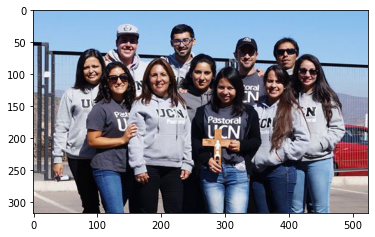

In [134]:
%pylab inline
image = plt.imread('piel-ucn.jpeg')
imgplot = plt.imshow(image)

print(image.shape)

print(image[0:10,0:10,0])

# Normalizo la imagen
image = image/255

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


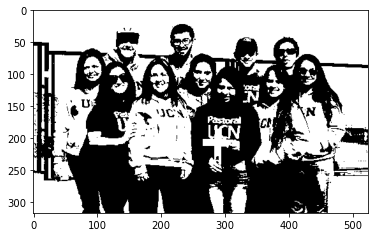

In [139]:
import numpy as np

mascara = np.zeros((image.shape[0], image.shape[1]))
for fil in range(image.shape[0]):
  for col in range(image.shape[1]):
    #print('#fil', fil, '#col', col)
    #Obtenmos el color rojo
    r = image[fil, col, 0]
    g = image[fil, col, 1]
    b = image[fil, col, 2]
    #print('( r=', r, ' g=', g, 'b=', b, ')')
    # Predecir si hay piel o  no
    if r > 0.5:
      mascara[fil, col] = 1

print(mascara)

plt.imshow(mascara, cmap='gray')

### Tarea Opcional:

* Entrenar otro clasificador, con redes neuronales utilizando los **hiperparámetros** encontrados en el laboratorio pero utilizando **todos** las instancias de la base de datos (Train+Valid).
* Segmentar la imagen propuesta, pintando de **blanco** los lugares donde existan **pixeles de color piel** y **negro** en aquellos **pixeles distintos a piel**.